In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [5]:
# tn_era5 = xr.open_mfdataset('%s/daily/tasmin_*.nc'%dirEra5)
# tn_era5 = tn_era5.sel(time=slice('1981', '2021'))
# tn_era5_mean = tn_era5.mean(dim='time')
# # tn_era5_mean.compute()
# tn_era5_mean.to_netcdf('era5_tasmin_mean.nc')

In [6]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [7]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [8]:
tx = xr.open_mfdataset(f"{dirEra5}/daily/tasmax_*.nc")
# tw = xr.open_dataset(f"{dirEra5}/daily/tw_max_2020.nc")
e = xr.open_mfdataset(f"{dirEra5}/daily/evaporation_*.nc")


In [9]:
from statsmodels.tsa.stattools import grangercausalitytests

In [10]:
tx_sel = tx.mx2t.sel(latitude=slice(45,35), longitude=slice(260,270), time=((tx['time.year'] >= 1981) & (tx['time.year'] <= 2000) & (tx['time.month'] >= 6) & (tx['time.month'] <= 9)))-273.15
tx_sel_mean = tx_sel.mean(dim=['latitude', 'longitude'])
# tw_sel = tw.tw.sel(latitude=slice(45,35), longitude=slice(260,270), time=slice('2020-06', '2020-09'))
e_sel = e.e.sel(latitude=slice(45,35), longitude=slice(260,270), time=((e['time.year'] >= 1981) & (e['time.year'] <= 2000) & (e['time.month'] >= 6) & (e['time.month'] <= 9)))
e_sel_mean = e_sel.mean(dim=['latitude', 'longitude'])

In [11]:
tx_sel_mean.load()
e_sel_mean.load()

<xarray.DataArray 'e' (time: 2440)>
array([-0.0037993 , -0.00310754, -0.00327531, ..., -0.00202635,
       -0.00213583, -0.00213045])
Coordinates:
  * time     (time) datetime64[ns] 1981-06-01 1981-06-02 ... 2000-09-30

In [12]:
def granger_causality_test(temp_series, et_series, max_lag, significance_level=0.05):
    data = pd.DataFrame({"Temperature": temp_series, "ET": et_series})
    gc_test_result = grangercausalitytests(data, max_lag, verbose=False)

    for lag, test_output in gc_test_result.items():
        p_value = test_output[0]["ssr_ftest"][1]
        if p_value < significance_level:
            return (lag, p_value)
    return None


In [15]:
temp_series = tx_sel_mean
et_series = e_sel_mean

gc_result = granger_causality_test(et_series, temp_series, max_lag)

In [16]:
gc_result

(1, 0.019608759080158585)

In [14]:
# Initialize result arrays
latitude = tx_sel.latitude
longitude = tx_sel.longitude
lag_result = xr.DataArray(np.empty((len(latitude), len(longitude))), coords=[latitude, longitude], dims=["latitude", "longitude"])
p_value_result = xr.DataArray(np.empty((len(latitude), len(longitude))), coords=[latitude, longitude], dims=["latitude", "longitude"])

# Loop through grid cells
max_lag = 12  # Set the maximum lag to consider
for lat in latitude:
    print(lat.values)
    for lon in longitude:
#         temp_series = tx_sel.sel(latitude=lat, longitude=lon).to_dataframe()["mx2t"]
#         et_series = e_sel.sel(latitude=lat, longitude=lon).to_dataframe()["e"]
        
        temp_series = tx_sel_mean
        et_series = e_sel_mean

        gc_result = granger_causality_test(et_series, temp_series, max_lag)

        if gc_result:
            lag_result.loc[lat, lon], p_value_result.loc[lat, lon] = gc_result
        else:
            lag_result.loc[lat, lon], p_value_result.loc[lat, lon] = np.nan, np.nan

# Save the results as xarray DataArrays
# lag_result.to_netcdf("granger_causality_lag_result.nc")
# p_value_result.to_netcdf("granger_causality_p_value_result.nc")


45.0
44.75


KeyboardInterrupt: 

In [ ]:
plt.plot(tw_sel.mean(dim=['latitude', 'longitude']).values/tw_sel.mean(dim=['time','latitude','longitude']).values)
plt.plot(e_sel.mean(dim=['latitude', 'longitude']).values/e_sel.mean(dim=['time','latitude','longitude']).values)
plt.xlim([0,10])

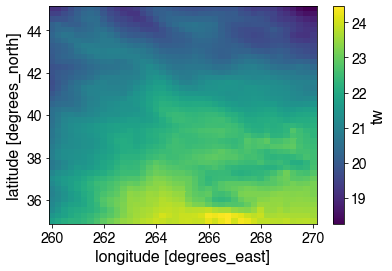

In [88]:
tw_sel.mean(dim='time').plot()

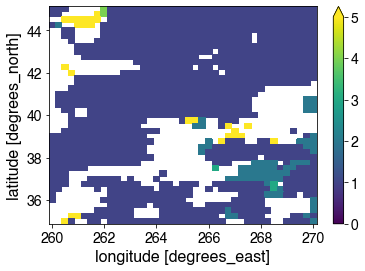

In [89]:
lag_result.plot(vmin=0,vmax=5)

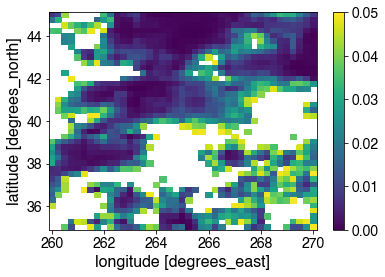

In [90]:
p_value_result.plot(vmin=0,vmax=.05)